In [2]:
# Connect to my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!mkdir forVideo
!mkdir makeVideo

In [4]:
# get every frame of my video

import cv2
vidcap = cv2.VideoCapture('/content/gdrive/MyDrive/self driving car/lane detection/20210304_150312.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("/content/forVideo/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

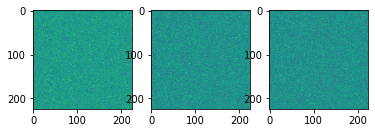

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ims = np.random.randn(3, 224, 224)

fig, ax = plt.subplots(1, 3)
for i in range(3):
    ax[i].imshow(ims[i])

(-0.5, 1919.5, 1079.5, -0.5)

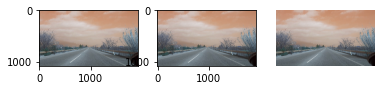

In [ ]:


fig, ax = plt.subplots(1, 3)
ax[0].imshow(lane_image)
ax[1].imshow(lane_image)
ax[2].imshow(lane_image)
plt.axis("off")

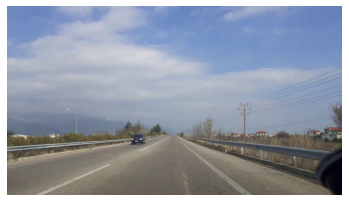

In [5]:
# read the image
import cv2
import matplotlib.pyplot as plt

image_path = "/content/forVideo/frame140.jpg"
lane_image = cv2.imread(image_path)
lane_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(lane_image)

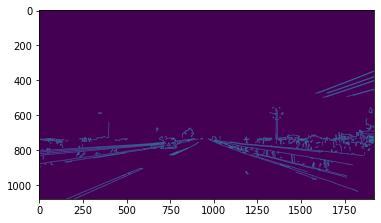

In [6]:
lane_image = cv2.imread(image_path)
blur = cv2.GaussianBlur(lane_image, (5,5), 0)
cannyImage = cv2.Canny(blur, 110, 50, L2gradient = True)

plt.imshow(cannyImage)


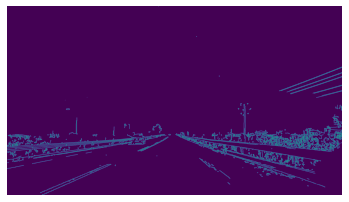

In [7]:
def CannyEdge(image):
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  blur = cv2.GaussianBlur(gray, (5,5), 0)
  # detection of the edges
  cannyImage = cv2.Canny(image, 160, 70, L2gradient = True)
  return cannyImage

# view the result
plt.axis("off")
cannyImage = plt.imshow(CannyEdge(lane_image))

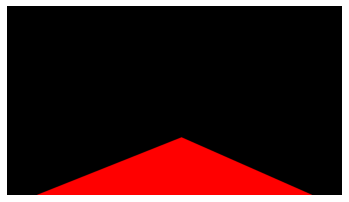

In [9]:
import numpy as np
height, width,_ = lane_image.shape
triangle = np.array([[(170, height),(1750, height),(1000, 750)]], np.int32)
mask = np.zeros_like(lane_image)
p = cv2.fillPoly(mask, triangle, 255)
plt.axis("off")
plt.imshow(p)

In [ ]:
import numpy as np
# image has to be gray scaled
def region_of_interest(image):
    height, width = image.shape
    triangle = np.array([[(100, height),(800, height),(1000, 750)]], np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, triangle, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image


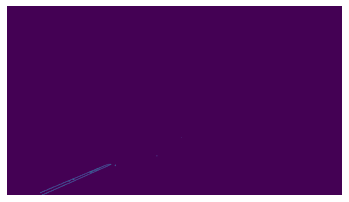

In [ ]:
# view the result
cannyImage = CannyEdge(lane_image)
cropped_Image = region_of_interest(cannyImage)
plt.axis("off")

plt.imshow(cropped_Image)



In [ ]:
rho = 2
theta = np.pi/180
threshold = 100
lines = cv2.HoughLinesP(cropped_Image,rho, theta, threshold, np.array ([ ]), minLineLength=80, maxLineGap=5)
print(lines)


[[[ 392  995  547  926]]

 [[ 194 1065  448  958]]

 [[ 388  984  482  944]]

 [[ 246 1060  595  905]]

 [[ 458  954  558  912]]]


In [ ]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

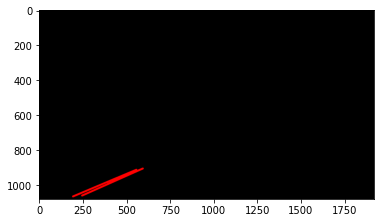

In [ ]:
line_image = display_lines(lane_image, lines)
#plt.axis("off")
plt.imshow(line_image)

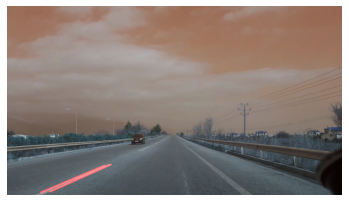

In [ ]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
plt.axis("off")

plt.imshow(combo_image)

EXPAND THE LINES

In [ ]:
# convert 2(slope,intercept) points line to 4(x1,y1,x2,y2)
def make_points(image, line_parameters):
    slope, intercept = line_parameters
    y1 = int(image.shape[0])
    y2 = int(y1*3/5)
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return [[x1, y1, x2, y2]]

In [ ]:
# gia na edopizei akoma kai mia grammi

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    if lines is None:
        return None
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    if not left_fit:
        left_line = [[0,0,0,0]]
    else:
        left_fit_average = np.average(left_fit, axis = 0)
        left_line = make_points(image, left_fit_average)
    if not right_fit:
        right_line = [[0,0,0,0]]
    else:
        right_fit_average = np.average(right_fit, axis = 0)
        right_line = make_points(image, right_fit_average)
    return np.array((left_line, right_line))
averaged_lines = average_slope_intercept(lane_image, lines)
print(averaged_lines)

[[[ 176 1080 1178  648]]

 [[   0    0    0    0]]]


In [ ]:
# otan edopizei 2 grammes

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    if lines is None:
        return None
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    left_line = make_points(image, left_fit_average)
    right_line = make_points(image, right_fit_average)
    return np.array((left_line, right_line))

averaged_lines = average_slope_intercept(lane_image, lines)
print(averaged_lines)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: ignored

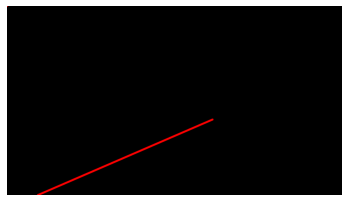

In [ ]:
line_image = display_lines(lane_image, averaged_lines)
plt.axis("off")
plt.imshow(line_image)

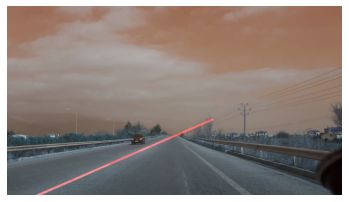

In [ ]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
plt.axis("off")

plt.imshow(combo_image)

In [ ]:
# take width and height of image
test = cv2.imread("/content/forVideo/frame0.jpg")
height, width, channels = test.shape
print(width, height)

1920 1080


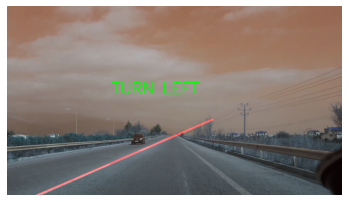

In [ ]:
left_line, right_line = averaged_lines
if left_line[0][0]!=0 or right_line[0][0]!=0:
    if left_line[0][0]==0:
        left_line[0][0] = right_line[0][0] - 1166
    if right_line[0][0]==0:
        right_line[0][0] = left_line[0][0] +1166
if ((right_line[0][0] + left_line[0][0])/2 > width/2 + 30):
    text = "TURN RIGHT"
elif ((right_line[0][0] + left_line[0][0])/2 < width/2 - 30):
    text = "TURN LEFT"
else:
    text = "GO STRAIGHT"
    
cv2.putText(combo_image, text ,
                        (600, 500), cv2.FONT_HERSHEY_SIMPLEX,
                        3.0, (0, 255, 0), 5)
plt.axis("off")
plt.imshow(combo_image)